In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely import wkt
import plotly.express as px
import os
import gdal
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import plotly.graph_objects as go
import glob
from functools import partial
import pyproj
from shapely.ops import transform
import osmnx as ox
from IPython.display import Image
import make_fishnet
import shapely.speedups
import geocoder
import pylab as pl
ox.config(log_console=True, use_cache=True)
pl.rcParams["figure.figsize"] = (10,10)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [91]:
def return_point(city):
    
    cities = {'Accra, Ghana': (-0.203739, 5.550775),
          'Buenos Aires, Argentina': (-58.371983, -34.608481), 
          #'Paris, France' : (2.239555, 48.891194), 
             'Paris, France': (2.305247, 48.874604),
          'Chicago, USA' : (-87.635393, 41.880952), 
          'Dhaka, Bangladesh': (90.417744, 23.729136), 
              'Shanghai, China' : (121.452817,31.253118)
          #'Shanghai, China' : (121.472155, 31.236955)
             }
    
    #string = city.split(',')[0]
    #dat = pd.read_csv("..\\GHSL_NewVersion\\GHSL_UCDB_new.csv")
    #df = dat[dat.UC_NM_MN == string]
    
    point = Point(cities[city])
    
    return point
    #import osmnx as ox
    
    #x = ox.gdf_from_place(city)['geometry'].iloc[0]
    
    #if x.geom_type == 'Point':
    #    return x
    #elif x.geom_type == 'Polygon':
    #    return x.centroid

In [92]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio accepts them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [93]:
def get_buffer_vars(city):
    
    point = return_point(city)
    buff_250 = point.buffer(0.005, 128)
    buff_500 = point.buffer(0.01, 128)
    dough_500 = buff_500.difference(buff_250)
    buff_1000 = point.buffer(0.015, 128)
    dough_1000 = buff_1000.difference(buff_500)
    buff_1500 = point.buffer(0.02, 128)
    dough_1500 = buff_1500.difference(buff_1000)
    buff_2000 = point.buffer(0.025, 128)
    dough_2000 = buff_2000.difference(buff_1500)
    buff_2500 = point.buffer(0.03, 128)
    dough_2500 = buff_2500.difference(buff_2000)
    buff_3000 = point.buffer(0.035, 128)
    dough_3000 = buff_3000.difference(buff_2500)
    buff_3500 = point.buffer(0.04, 128)
    dough_3500 = buff_3500.difference(buff_3000)
    buff_4000 = point.buffer(0.045, 128)
    dough_4000 = buff_4000.difference(buff_3500)
    
    return buff_250, dough_500, dough_1000, dough_1500, dough_2000, dough_2500, dough_3000, dough_3500, dough_4000

In [94]:
def convert_geom_to_shp(shapely_polygon, city, out_name_postfix):
    string = city.split(',')[0]
    
    df = pd.DataFrame(
    {'City': [string],
     'geometry': [wkt.dumps(shapely_polygon)]})
    
    df['geometry'] = df['geometry'].apply(wkt.loads)
    
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    gdf.crs = {'init' : 'epsg:4326'}
    
    path = "M:\Gaurav\GPSUR\Data\Analysis"
    
    gdf.to_file(path+'\\shapefiles\\{a}_{b}.shp'.format(a=string, b=out_name_postfix))
    
    return path+'\\shapefiles\\{a}_{b}.shp'.format(a=string, b=out_name_postfix)

In [95]:
def reproject_raster(source_path, destination_path):

    dst_crs = 'EPSG:4326'
    
    try:
        with rasterio.open(source_path, CHECK_DISK_FREE_SPACE =False) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': dst_crs,
                'transform': transform,
                'width': width,
                'height': height
            })

            with rasterio.open(destination_path, 'w',**kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest)
    except rasterio._err.CPLE_FileIOError:
        print('File too big! Cant open')
    except rasterio._base.RasterioIOError:
        print('Raster file empty!')

In [96]:
def clip_density(shp_path, raster_path, year):
    
    shp = gpd.read_file(shp_path)
    shp.crs = {'init':'epsg:4326'}
    shp = shp.to_crs(epsg=4326)
    
    coords = getFeatures(shp)
    
    new = rasterio.open(raster_path)
    
    try:
        out_img, out_transform = mask(dataset=new, shapes=coords, crop=True)
        out_img[out_img < 1985] = 0
        out_img[out_img > year] = -1
        out_img[(out_img >= 1985) & (out_img <= year)] = 1
        return np.round((out_img[out_img == 1].shape[0] / out_img[out_img != 0].shape[0]) * 100, 3)
        
    except ValueError:
        print('No Overlap between raster and polygon.')
        return

In [103]:
def main_dlr(city):
    string = city.split(',')[0]
    
    #point = return_point(city)
    
    path = r"M:\Gaurav\GPSUR\Data\DLR Data"
    
    #temp = glob.glob(path+'\*WSFEvolution.tif')
    temp = glob.glob(path+'\*WSF3D_AW3D30.tif') 
    
    buff_250, buff_500, buff_1000, buff_1500, buff_2000, buff_2500, buff_3000, buff_3500, buff_4000 = get_buffer_vars_dlr(city)
    
    dic = {'250m':buff_250, '500m':buff_500, '1000m':buff_1000, '1500m':buff_1500, '2000m':buff_2000, '2500m':buff_2500,
          '3000m':buff_3000, '3500m':buff_3500, '4000m':buff_4000}
    
    shp_lis = []
    for res in dic.keys():  
        shp_lis.append(convert_geom_to_shp(dic[res], city, res))
    
    sum_dic = {}

    for year in [1985, 1990, 1995, 2000, 2005, 2010, 2015]:
        for ras_path in temp:
            if "".join(string.split()) in ras_path:
                sum_lis = []

                for shp in shp_lis:
                    sum_lis.append(clip_density(shp, ras_path, year))
                sum_dic[year] = sum_lis
    return sum_dic

In [98]:
def clip_density_dlr(gdf, raster_path, year):
    
    coords = getFeatures(gdf)
    
    new = rasterio.open(raster_path)
    
    try:
        out_img, out_transform = mask(dataset=new, shapes=coords, crop=True)
        out_img[out_img < 1985] = 0
        out_img[out_img > year] = -1
        out_img[(out_img >= 1985) & (out_img <= year)] = 1
        return np.round((out_img[out_img == 1].shape[0] / out_img[out_img != 0].shape[0]) * 100, 3)
        
    except ValueError:
        print('No Overlap between raster and polygon.')
        return

In [99]:
def convert_geom_to_shp_dlr(shapely_polygon, city):
    string = city.split(',')[0]
    
    df = pd.DataFrame(
    {'City': [string],
     'geometry': [wkt.dumps(shapely_polygon)]})
    
    df['geometry'] = df['geometry'].apply(wkt.loads)
    
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    
    gdf.crs = {'init' : 'epsg:4326'}
    
    
    return gdf

In [100]:
def get_buffer_vars_dlr(city):
    
    point = return_point(city)
    buff_2000 = point.buffer(0.025, 128)
    buff_4000 = point.buffer(0.045, 128)
    dough_4000 = buff_4000.difference(buff_2000)
    buff_6000 = point.buffer(0.065, 128)
    dough_6000 = buff_6000.difference(buff_4000)
    buff_8000 = point.buffer(0.085, 128)
    dough_8000 = buff_8000.difference(buff_6000)
    buff_10000 = point.buffer(0.105, 128)
    dough_10000 = buff_10000.difference(buff_8000)

    return buff_2000, dough_4000, dough_6000, dough_8000, dough_10000

In [160]:
buff_2000, buff_4000, buff_6000, buff_8000, buff_10000 = get_buffer_vars_dlr("Shanghai, China")

In [161]:
geom = convert_geom_to_shp_dlr(buff_4000, 'Shanghai')
coords = getFeatures(geom)

In [162]:
src = rasterio.open(r"M:\Gaurav\GPSUR\Data\DLR Data\Shanghai_WSFevolution.tif")

In [183]:
out_img, out_transform = mask(dataset=src, shapes=coords, crop=True)

In [184]:
out_img = out_img.reshape(out_img.shape[1], out_img.shape[2])
out_img_2000 = out_img.copy()

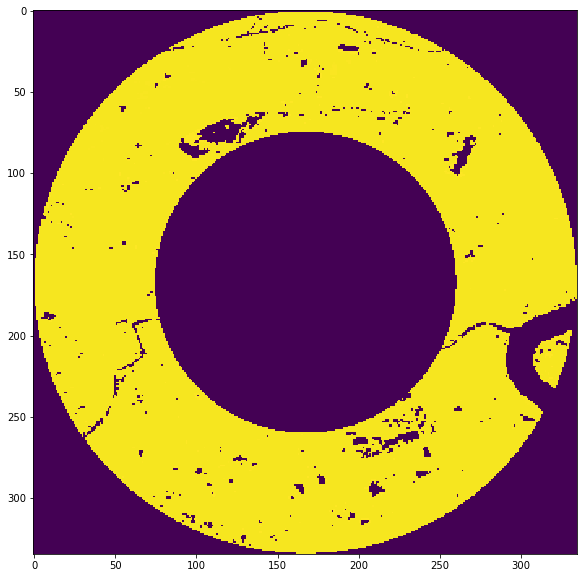

In [165]:
pl.imshow(out_img)

### 1985 builtup extent

In [166]:
out_img[out_img < 1985] = 0
out_img[out_img > 1985] = -1
out_img[(out_img >= 1985) & (out_img <= 1985)] = 1

In [167]:
np.unique(out_img)

array([-1,  0,  1], dtype=int16)

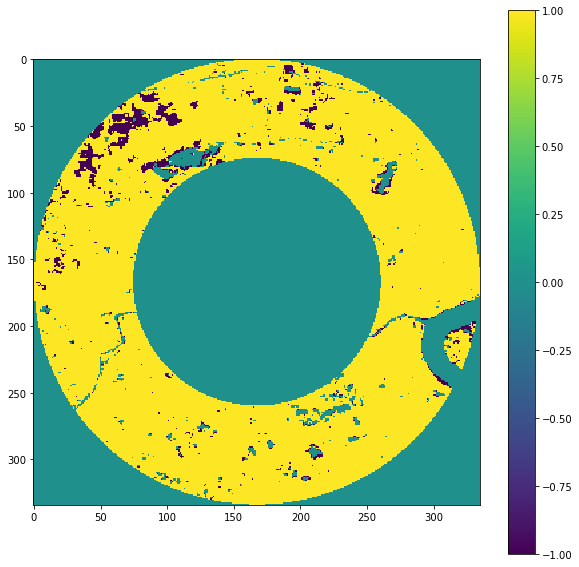

In [168]:
im = pl.imshow(out_img, cmap='viridis')
pl.colorbar(im)

In [169]:
x = (out_img[out_img == 1].shape[0] / out_img[out_img != 0].shape[0]) * 100
print("% built-up in 1985 at 4000m buffer: {}".format(np.round(x,3)))

% built-up in 1985 at 4000m buffer: 95.489


#### Entire land area

In [170]:
point = return_point('Shanghai, China')

In [171]:
buff_4000 = point.buffer(0.045, 128)

In [172]:
string = 'Chicago'
df_ = pd.DataFrame(
    {'City': [string],
     'geometry': [wkt.dumps(buff_4000)]})

df_['geometry'] = df_['geometry'].apply(wkt.loads)

gdf_ = gpd.GeoDataFrame(df_, geometry='geometry')

gdf_.crs = {'init' : 'epsg:4326'}

In [173]:
coords_ = getFeatures(gdf_)

In [174]:
out_img_all, out_transform_all = mask(dataset=src, shapes=coords_, crop=True)

In [175]:
out_img_all = out_img_all.reshape(out_img_all.shape[1], out_img_all.shape[2])
out_img_all_2000 = out_img_all.copy()

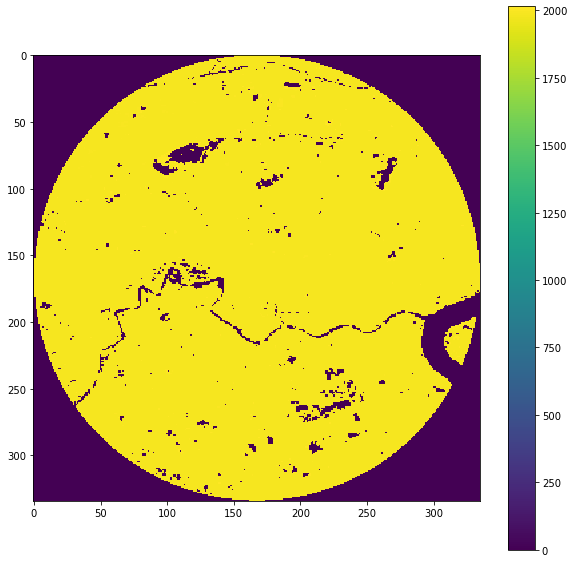

In [176]:
ax_1 = pl.imshow(out_img_all)
pl.colorbar(ax_1)

In [177]:
out_img_all[out_img_all < 1985] = 0
out_img_all[out_img_all >= 1985] = 1

In [178]:
np.unique(out_img_all)

array([0, 1], dtype=int16)

In [179]:
out_img_all[out_img_all >0].shape, out_img[out_img == 1].shape[0]

((83432,), 54656)

In [180]:
x_ = (out_img[out_img == 1].shape[0] / out_img_all[out_img_all == 1].shape[0]) * 100
print("% built-up in 1985 at 4000m buffer: {}".format(np.round(x_,3)))

% built-up in 1985 at 4000m buffer: 65.51


### 2000 builtup extent

In [185]:
out_img_2000[out_img_2000 < 1985] = 0
out_img_2000[out_img_2000 >2000] = -1
out_img_2000[(out_img_2000 >= 1985) & (out_img_2000 <= 2000)] =  1

In [186]:
np.unique(out_img_2000)

array([-1,  0,  1], dtype=int16)

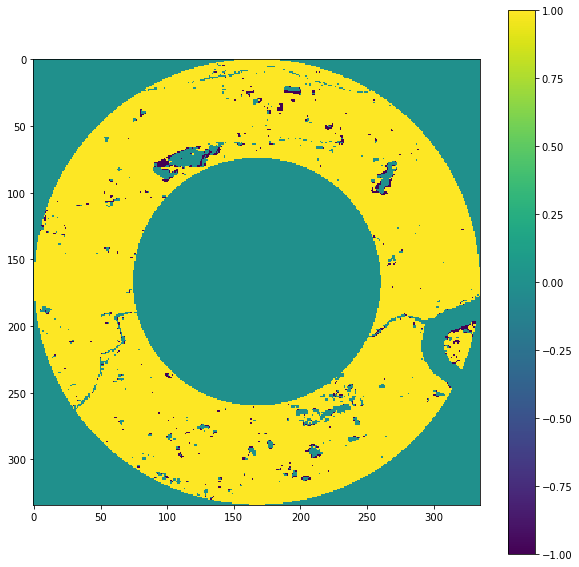

In [187]:
im_ = pl.imshow(out_img_2000, cmap='viridis')
pl.colorbar(im_)

In [188]:
y = (out_img_2000[out_img_2000 == 1].shape[0] / out_img_2000[out_img_2000 != 0].shape[0]) * 100
print("% built-up in 1985 at 4000m buffer: {}".format(np.round(y,3)))

% built-up in 1985 at 4000m buffer: 98.454


In [190]:
_x_ = (out_img_2000[out_img_2000 == 1].shape[0] / out_img_all[out_img_all == 1].shape[0]) * 100
print("% built-up in 1985 at 4000m buffer: {}".format(np.round(_x_,3)))

% built-up in 1985 at 4000m buffer: 67.544


In [83]:
def main2_dlr(city):
    string = city.split(',')[0]
    
    #point = return_point(city)
    
    path = r"M:\Gaurav\GPSUR\Data\DLR Data"
    
    #temp = glob.glob(path+'\*WSFEvolution.tif')
    temp = glob.glob(path+'\*WSFevolution.tif') 
    
    buff_2000, buff_4000, buff_6000, buff_8000, buff_10000 = get_buffer_vars_dlr(city)
    
    sum_dic = {}

    for year in [1985, 2000, 2015]:
        for ras_path in temp:
            if "".join(string.split()) in ras_path:
                sum_lis = []

                for i in [buff_2000, buff_4000, buff_6000, buff_8000, buff_10000]:
                    gdf = convert_geom_to_shp_dlr(i, city)
                    sum_lis.append(clip_density_dlr(gdf, ras_path, year))
                sum_dic[year] = sum_lis
    return sum_dic

In [85]:
main2_dlr('Shanghai, China')

{1985: [98.58, 95.489, 91.331, 84.537, 72.268],
 2000: [99.183, 98.454, 98.457, 97.415, 92.617],
 2015: [100.0, 100.0, 100.0, 100.0, 100.0]}

In [88]:
cities = {'Accra, Ghana': (-0.203739, 5.550775),
          'Buenos Aires, Argentina': (-58.371983, -34.608481), 
          'Paris, France' : (2.239555, 48.891194), 
          'Chicago, USA' : (-87.635393, 41.880952), 
          'Dhaka, Bangladesh': (90.417744, 23.729136), 
          'Shanghai, China' : (121.472155, 31.236955)}

In [105]:
master = {}
for i in cities.keys():
    master[i] = main2_dlr(i)

In [106]:
master

{'Accra, Ghana': {1985: [98.541, 99.61, 99.18, 95.454, 98.26],
  2000: [99.215, 99.673, 99.336, 95.865, 98.336],
  2015: [100.0, 100.0, 100.0, 100.0, 100.0]},
 'Buenos Aires, Argentina': {1985: [95.941, 96.891, 95.486, 94.008, 95.302],
  2000: [98.573, 99.001, 98.326, 98.063, 98.497],
  2015: [100.0, 100.0, 100.0, 100.0, 100.0]},
 'Paris, France': {1985: [96.964, 97.28, 97.217, 96.171, 94.076],
  2000: [98.861, 98.886, 98.764, 98.277, 97.76],
  2015: [100.0, 100.0, 100.0, 100.0, 100.0]},
 'Chicago, USA': {1985: [96.507, 97.847, 98.756, 98.106, 97.947],
  2000: [97.914, 98.917, 99.569, 99.456, 99.499],
  2015: [100.0, 100.0, 100.0, 100.0, 100.0]},
 'Dhaka, Bangladesh': {1985: [93.057, 76.657, 69.867, 69.725, 77.438],
  2000: [97.782, 91.733, 83.729, 81.73, 88.274],
  2015: [100.0, 100.0, 100.0, 100.0, 100.0]},
 'Shanghai, China': {1985: [98.58, 95.489, 91.331, 84.537, 72.268],
  2000: [99.183, 98.454, 98.457, 97.415, 92.617],
  2015: [100.0, 100.0, 100.0, 100.0, 100.0]}}

### with OSM data

In [12]:
point = ox.gdf_from_place("Accra, Ghana")['geometry'].iloc[0]

C:\Users\wb542830\AppData\Roaming\Python\Python36\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [15]:
G = ox.graph_from_point((point.y, point.x), distance = 5000, network_type='drive')

In [16]:
import networkx as nx

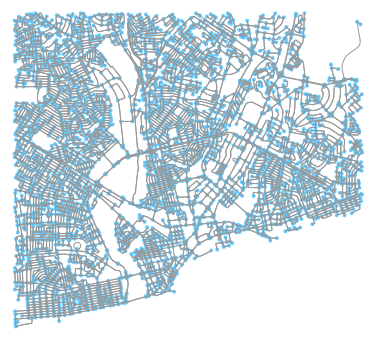

(<Figure size 481.549x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e7f7c30320>)

In [18]:
ox.plot_graph(G)

In [39]:
def get_geometry(string):
    

    boundary_GDF = ox.gdf_from_place('{}'.format('{}'.format(string)),which_result=1)
    boundary_poly = boundary_GDF.loc[0,'geometry']
    if boundary_poly.geom_type == 'Polygon':
        boundary_poly = boundary_poly
    elif boundary_poly.geom_type == 'Point':       
        boundary_poly = boundary_poly.buffer(0.05, 128).envelope
    
    return boundary_poly if boundary_poly.geom_type in ['Polygon'] else None

In [41]:
def get_graph(place):
    string = place.split(',')[0]
    
    print('Fetching graph data for {}'.format(place))
    
    poly = get_geometry(place)
    
    if not poly:
        gdf = ox.gdf_from_place('{}'.format(string))
        G = ox.graph_from_bbox(gdf.bbox_north, gdf.bbox_south, gdf.bbox_east, gdf.bbox_west)
    else:
        if poly.geom_type == 'Polygon':
            G = ox.graph_from_polygon(poly, network_type='drive')
        elif poly.geom_type == 'Point':
            G = ox.graph_from_point((poly.y, poly.x), distance = 5000, network_type='drive')
        else:
            print('No geometry')

    G = ox.project_graph(G)
    
    return G

In [46]:
G = get_graph('Accra, Ghana')

Fetching graph data for Accra, Ghana


C:\Users\wb542830\AppData\Roaming\Python\Python36\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
C:\Users\wb542830\AppData\Roaming\Python\Python36\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Point


In [90]:
def reproject_poly(polygon, in_epsg=None, out_epsg=None):
    
    if not in_epsg:
        in_epsg = 'epsg:3857' 
    if not out_epsg:
        out_epsg = 'epsg:4326'
    
    project = partial(
        pyproj.transform,
        pyproj.Proj(init= in_epsg), # source coordinate system
        pyproj.Proj(init= out_epsg)) # destination coordinate system

    geom = transform(project, polygon)
    
    return geom

In [191]:
def get_node_count(place_name, pixel_size=None):
    
    ## Setting initial crs
    crs = {'init':'epsg:4326'}
    
    string = place_name.split(',')[0]
    
    print('Fetching network data from OSM for {}'.format(place_name))
    
    ## Grabbing data from OSM
    G = get_graph(place_name)
    
    gdf_proj = ox.graph_to_gdfs(G, nodes=True, edges=False)
    gdf_proj = gdf_proj.to_crs(crs)
    
    geom = get_geometry(place_name)

    geom2bounds = reproject_poly(geom, 'epsg:4326', 'epsg:3857' ).bounds

    if pixel_size:
        size = pixel_size
    else:
        size = 500
    
    print('Creating fishnet')
    
    ## Creating fishnet and exporting the file
    try:
        os.mkdir('data/grid_data')
    except FileExistsError:
        pass
    except FileNotFoundError:
        os.mkdir('data')
        os.mkdir('data/grid_data')
        
    
    make_fishnet.main('data/grid_data/Road_grid_{}.shp'.format(string), geom2bounds[0], geom2bounds[2], 
                      geom2bounds[1], geom2bounds[3], size, size)
    grid = gpd.GeoDataFrame.from_file('data/grid_data/Road_grid_{}.shp'.format(string))
    
    if not grid.crs:
        grid.crs = {'init':'epsg:3857'}
        
    grid.to_crs(epsg=4326, inplace=True)
    
    #for i in grid.index:
    #    grid['geometry'][i] = reproject_poly(grid['geometry'][i])
    
    
    gdf_proj = gdf_proj.reset_index()
    
    ## Cleaning up the data by rmeoving invalid geometries
    
    gdf_proj = gdf_proj.rename(columns ={'index':'id'})
    gdf_proj['geomType'] = gdf_proj.geom_type
    gdf_proj = gdf_proj[gdf_proj['geomType'] != 'GeometryCollection']
    
    print('Merging datasets and calculating the count of nodes in each pixel')
    
    merged = gpd.sjoin( grid, gdf_proj, how='left', op='intersects')
    grp = merged.groupby('FID').count()
    
    grid['node_count'] = grp.id
    
    try:
        os.mkdir('data/{}'.format(string))
    except FileExistsError:
        pass

    grid.to_file('data/{a}/{a}_roads_fishnet.shp'.format(a=string))
    
    file = gpd.read_file('data/{a}/{a}_roads_fishnet.shp'.format(a=string))
    
    file = file[file.node_count !=0]
    
    file_max = file[file.node_count == file.node_count.max()]
    
    return file_max.geometry.iloc[0].centroid

In [168]:
get_node_count('Paris, France', 300)

Fetching network data from OSM for Paris, France
Fetching graph data for Paris, France


C:\Users\wb542830\AppData\Roaming\Python\Python36\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning:

Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings



Creating fishnet
Merging datasets and calculating the count of nodes in each pixel


In [169]:
shp = gpd.read_file("data/Paris/Paris_roads_fishnet.shp")

In [172]:
len(shp)

2159

In [171]:
shp = shp[shp.node_count !=0]

In [173]:
shp.node_count.max()

21

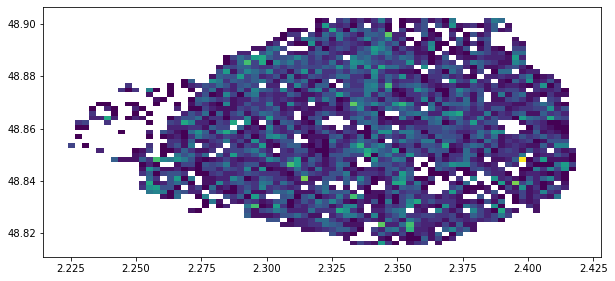

In [174]:
shp.plot(column='node_count', cmap='viridis', figsize=[10,10])

In [175]:
G_paris = get_graph("Paris, France")

Fetching graph data for Paris, France


In [176]:
nodes_paris = ox.graph_to_gdfs(G_paris, nodes=True, edges=False)

In [177]:
len(nodes_paris)

10070

In [178]:
nodes_paris.to_file("data/paris_nodes.shp")